## Projet Qualia - SNCF

In [71]:
%matplotlib notebook
import matplotlib.pylab as plt

## file handling
from os import listdir
from os.path import isfile, join
from fnmatch import fnmatch
import subprocess
import shlex
import re

## images
import ipywidgets as ipyw
import cv2 
import numpy as np 
from numpy import linalg as la
from PIL import Image

import skimage
import skimage.exposure
import skimage.io
from skimage.morphology import erosion, disk

from skimage.exposure import equalize_adapthist as clahe

In [42]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    
    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [43]:
def imgMatch(movingImg, refImg, debug=False):
    height, width = refImg.shape 
    # Create ORB detector with 5000 features. 
    orb_detector = cv2.ORB_create(5000) 
  
    # Find keypoints and descriptors. 
    # The first arg is the image, second arg is the mask 
    #  (which is not required in this case). 
    kp1, d1 = orb_detector.detectAndCompute(movingImg, None) # moving
    kp2, d2 = orb_detector.detectAndCompute(refImg, None) # ref
    
    ## eliminate keypoints too close to the zero border
    # maskref = refImg !=0
    # maskmov = movingImg != 0
    # maskinter = maskref * maskmov ## intersection
    # maskerod = erosion(maskinter,disk(5))
    # if (debug):
    #    Image.fromarray(maskerod)
        
    
  
    # Match features between the two images. 
    # We create a Brute Force matcher with  
    # Hamming distance as measurement mode. 
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 
  
    # Match the two sets of descriptors. 
    matches = matcher.match(d1, d2) 
  
    # Sort matches on the basis of their Hamming distance. 
    matches.sort(key = lambda x: x.distance) 
  
    # Take the top 10 % matches forward. 
    matches = matches[:int(len(matches)*.10)] 
    no_of_matches = len(matches) 
    
    print("Number of matches ", no_of_matches)
  
    # Define empty matrices of shape no_of_matches * 2. 
    p1 = np.zeros((no_of_matches, 2)) 
    p2 = np.zeros((no_of_matches, 2)) 
  
    for i in range(len(matches)): 
      p1[i, :] = kp1[matches[i].queryIdx].pt 
      p2[i, :] = kp2[matches[i].trainIdx].pt 
  
    # Find the homography matrix. 
    homography, mask = cv2.findHomography(p1, p2, method=cv2.RANSAC,ransacReprojThreshold=1.0) 
    
    # sanity check
    sanity = la.norm((homography - np.identity(3))[0:3,0:2])
  
    # Use this matrix to transform the 
    # colored image wrt the reference image. 
    transformed_img = cv2.warpPerspective(movingImg, 
                        homography, (width, height))
    
    return(transformed_img, sanity)

In [77]:
class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed. 

    Argumentss:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('plasma'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, volume, figsize=(8,8), cmap='plasma'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]
        
        # Call to select slice plane
        ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y', 
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))
        
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
    
    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1
        
        # Call to view a slice within the selected slice plane
        ipyw.interact(self.plot_slice, 
            z=ipyw.IntSlider(min=0, max=maxZ, step=1, continuous_update=False, 
            description='Image Slice:'))
        
    def plot_slice(self, z):
        plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])

In [45]:
pattern="img_*.png"
pathimgs="data/imgs"
pathlist = [pathimgs+"/"+f for f in listdir(pathimgs) if fnmatch(f,pattern)]
print(pathlist[0:10])

['data/imgs/img_1568902518.813932.png', 'data/imgs/img_1568201529.318426.png', 'data/imgs/img_1568620618.573221.png', 'data/imgs/img_1569235168.774667.png', 'data/imgs/img_1568352268.311445.png', 'data/imgs/img_1568981447.345805.png', 'data/imgs/img_1569252994.218316.png', 'data/imgs/img_1568986979.041494.png', 'data/imgs/img_1568891765.217891.png', 'data/imgs/img_1569084930.337907.png']


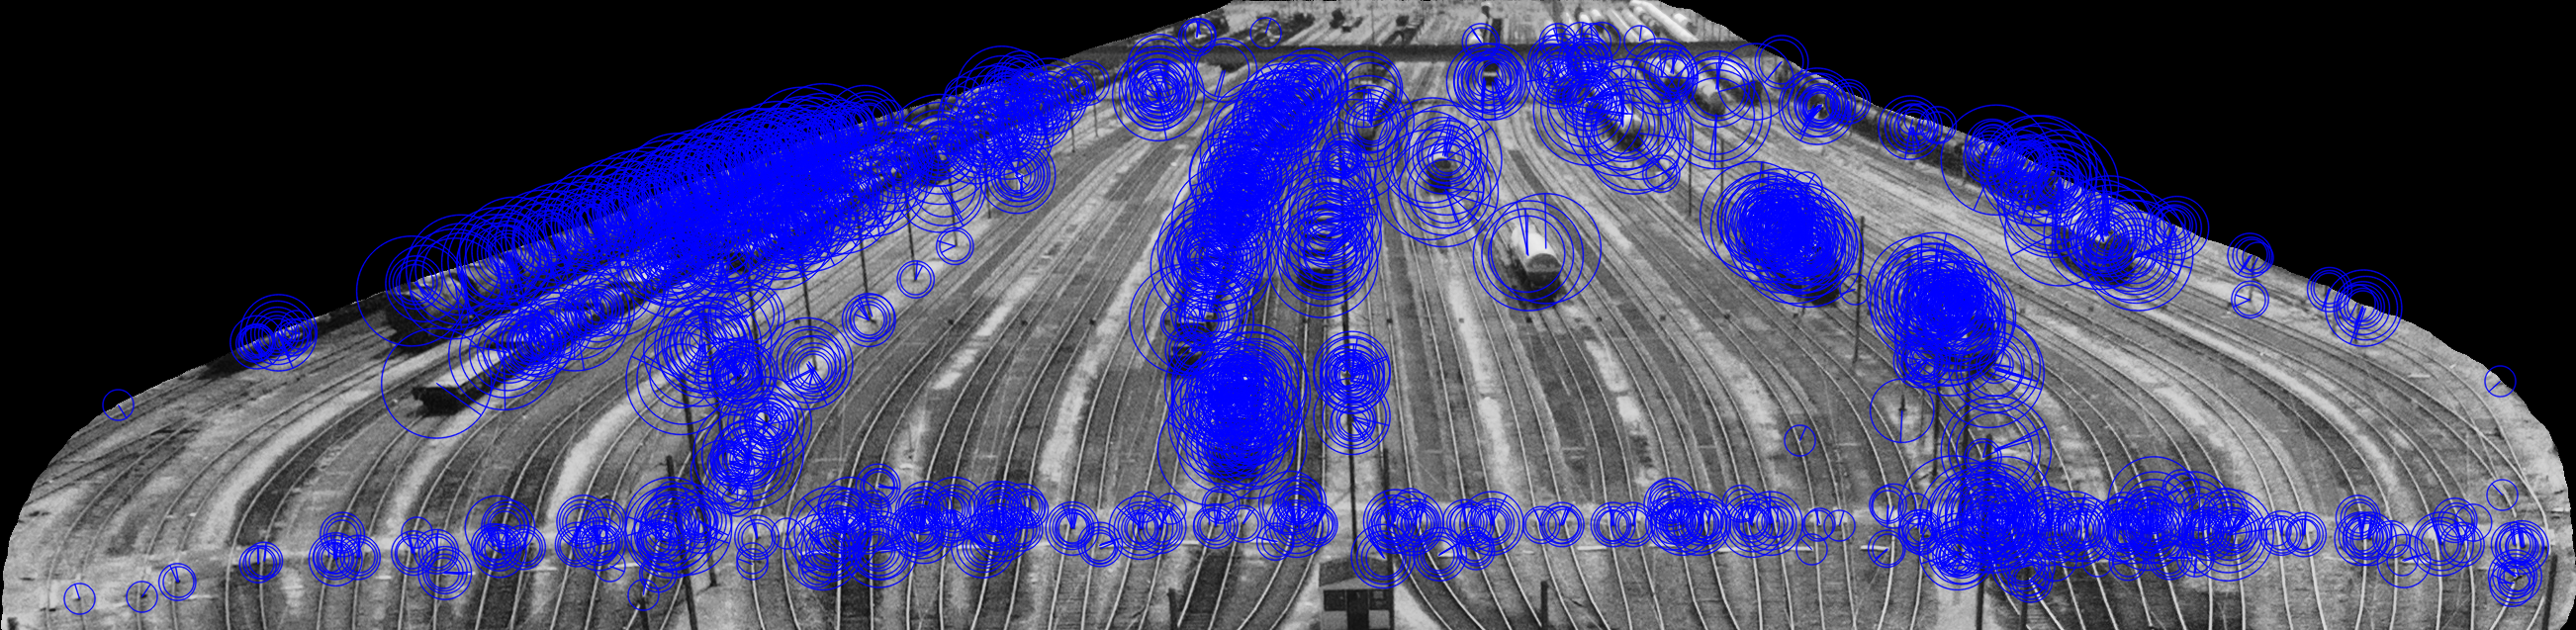

In [46]:
imgref = cv2.imread(pathlist[1])
img=Image.fromarray(imgref)

orb_detector = cv2.ORB_create(2000) 
kp1, d1 = orb_detector.detectAndCompute(imgref, None)
kp1[0].pt

img2 = cv2.drawKeypoints(imgref, kp1, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
Image.fromarray(img2)

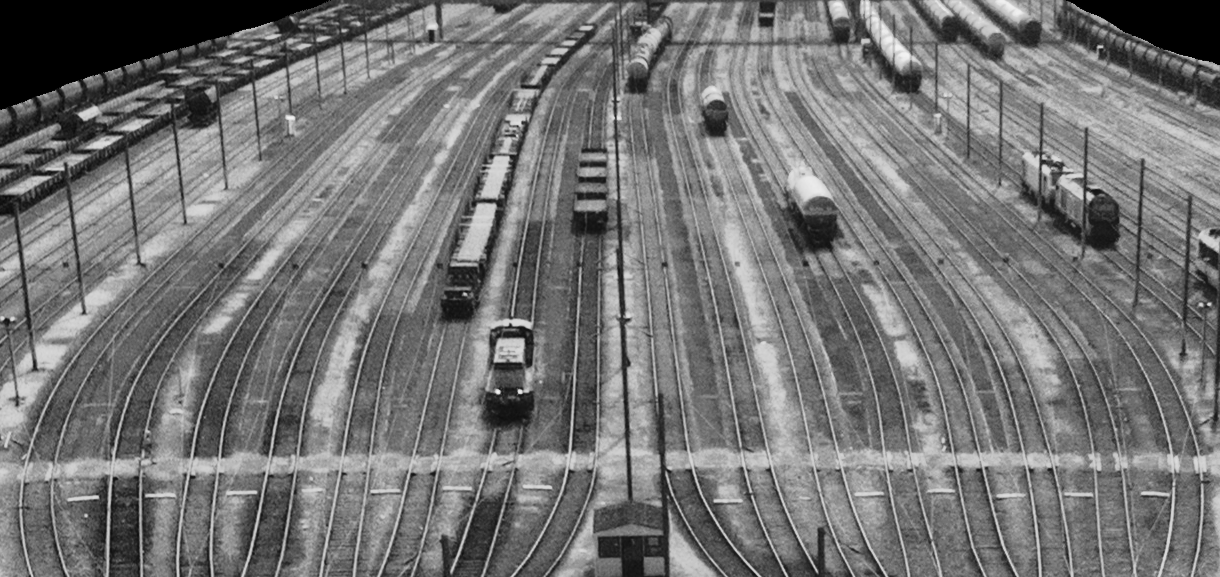

In [47]:
## interesting dimensions
## col: 760-2600
## row: 340-1000
row1=60
row2=1001
col1=740
col2=1960
cropref = imgref[row1:row2,col1:col2]
# cv2.imwrite('cropreference.jpg',cropref)
# cv2.imwrite('cropwarped.jpg', croptrans) 
Image.fromarray(cropref)

In [112]:
histocropmatch = hist_match(croptrans,cropref)
cv2.imwrite('histomatch.jpg', histocropmatch) 

True

In [55]:
%%time
CROP=False
multiprocessing=True

import multiprocessing as mp
from joblib import Parallel, delayed


## try on the whole thing
nbimages = len(pathlist)

## create 3D structure
imgcube = []

img1_color = cv2.imread(pathlist[1])    # Reference image. 
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY) 
cimg1 = (256*clahe(img1,nbins=256)).astype(np.uint8)

if CROP:
    cropref =cimg1[row1:row2,col1:col2]
else:
    cropref = cimg1[:,:]
    
def readConvertWarp(path):
    img2_color = cv2.imread(path)  # Image to be aligned.   
    # Convert to grayscale. 
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY) 
    
    # quick check if too dark
    ave = np.average(img2)
    print("%d " % ave, end='')
    if np.average(img2) < 50:
        #print("too dark", end='')
        result = None
    else:
        # Histogram equal
        cimg2 = (256*clahe(img2,nbins=256)).astype(np.uint8)
        # transform/warp/register
        transformedImg, sanity = imgMatch(cimg2,cimg1) ## moving, ref
        if (sanity < 0.1):
            # crop
            if (CROP):
                croptrans=transformedImg[row1:row2,col1:col2]  
            else:
                croptrans=transformedImg[:,:]
            # histogram match
            histocropmatch = hist_match(croptrans,cropref)
            result = histocropmatch
        else:
            #print("sanity=%3.2f, Incorrect transform" % sanity, end='')
            result = None
    #print("")
    return result

def readConvertNoWarp(path):
    img2_color = cv2.imread(path)  # Image to be aligned.   
    # Convert to grayscale. 
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY) 
    
    # quick check if too dark
    ave = np.average(img2)
    print("%d " % ave, end='')
    if np.average(img2) < 100:
        #print("too dark", end='')
        result = None
    else:
        if CROP:
            cropped = img2[row1:row2,col1:col2]
        else:
            cropped = img2[:,:]
        # Histogram equal
        cimg2 = (256*clahe(cropped,nbins=256)).astype(np.uint8)
        result = hist_match(cimg2,cropref)
    return result

def testStupid(path):
    return path

if (not multiprocessing):
    for i in range(1,int(nbimages)):
        print("%d," % i, end='')
        imgcube.append(readConvertWarp(pathlist[i]))
        ## None(s) will be removed later in a list comprehension
else:
    # parallel proc
    imgcube= Parallel(n_jobs=4,prefer="threads")(delayed(readConvertWarp)(path) for path in pathlist)
    # imgcube2 = [pool.apply(readConvertWarp, args=(path,)) for path in pathlist]

86 80 88 95 Number of matches  500
87 Number of matches  178
Number of matches  140
84 93 Number of matches  151
Number of matches  151
91 80 Number of matches  188
88 Number of matches  146
Number of matches  189
92 Number of matches  138
90 89 Number of matches  135
Number of matches  132
84 Number of matches  133
83 90 Number of matches  160
Number of matches  135
89 94 Number of matches  132
94 Number of matches  143
90 Number of matches  130
Number of matches  142
80 92 Number of matches  188
Number of matches  175
86 Number of matches  131
88 77 Number of matches  135
Number of matches  126
87 92 Number of matches  167
83 Number of matches  142
Number of matches  131
81 84 Number of matches  135
Number of matches  203
Number of matches  141
79 Number of matches  136
93 90 Number of matches  196
88 84 Number of matches  131
Number of matches  135
92 Number of matches  132
89 90 Number of matches  134
84 Number of matches  131
Number of matches  130
89 87 Number of matches  145
Num

In [58]:
## remove the None(s)
allimg=np.array([image for image in imgcube if image is not None])
print(allimg.shape)

(174, 637, 2604)


AttributeError: module 'numpy' has no attribute 'mult'

In [63]:
(174*637*2604*8)/(1000000)

2308.977216

In [64]:
## make 3d cube
np.save("allimg_noncompressed",allimg)
np.savez("allimg", allimg)

In [143]:
allfiles=np.load("allimg.npz")
allimg=allfiles['arr_0']

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

<IPython.core.display.Javascript object>


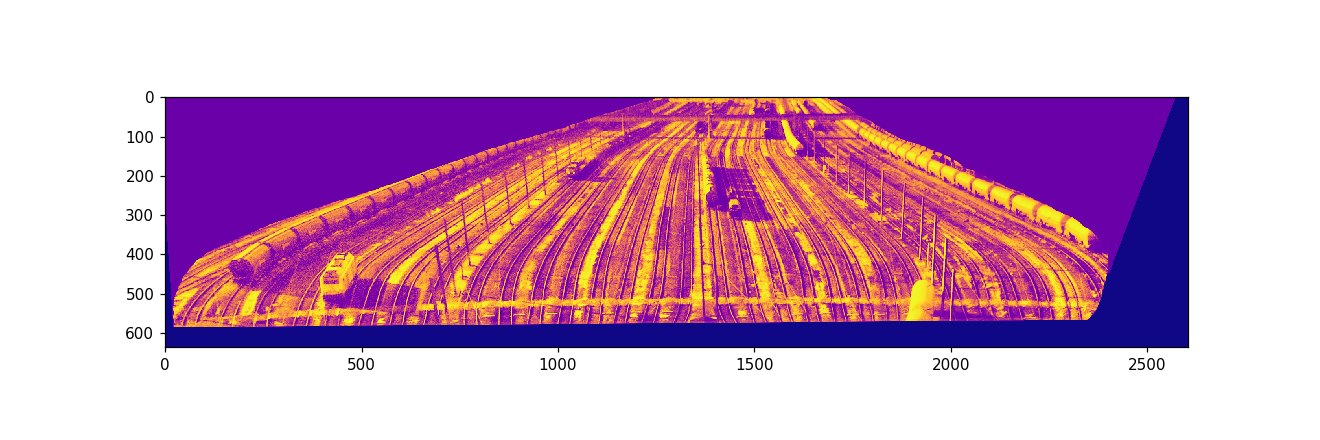

In [86]:
ImageSliceViewer3D(allimg, figsize=(12,4))

## Constructing the empty image

<IPython.core.display.Javascript object>


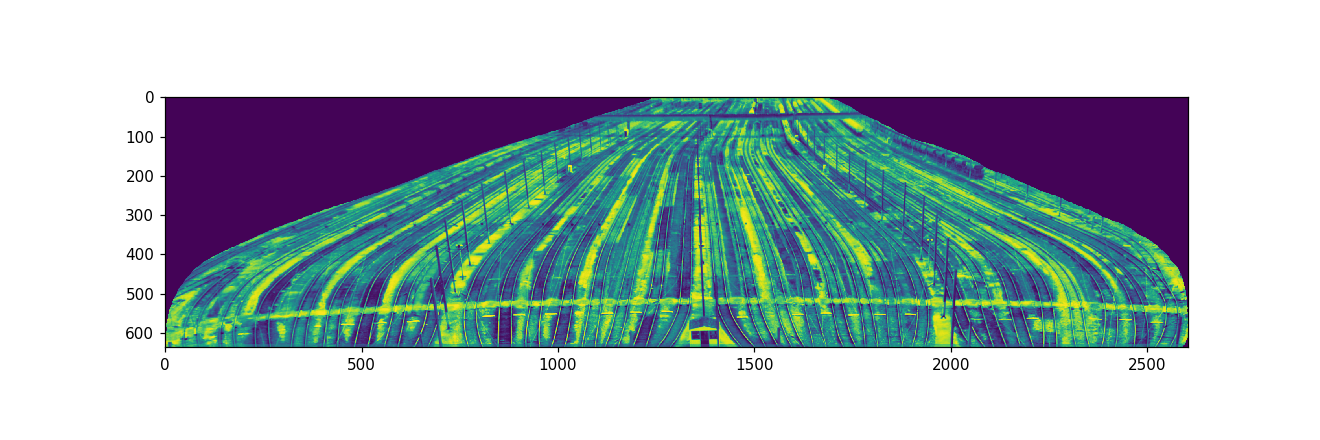

In [69]:
medimg = np.median(allimg,axis=0)
cv2.imwrite('medianref.jpg',medimg)

plt.figure(figsize=(12,4))
plt.imshow(medimg,cmap='')

## Testing difference image

<IPython.core.display.Javascript object>


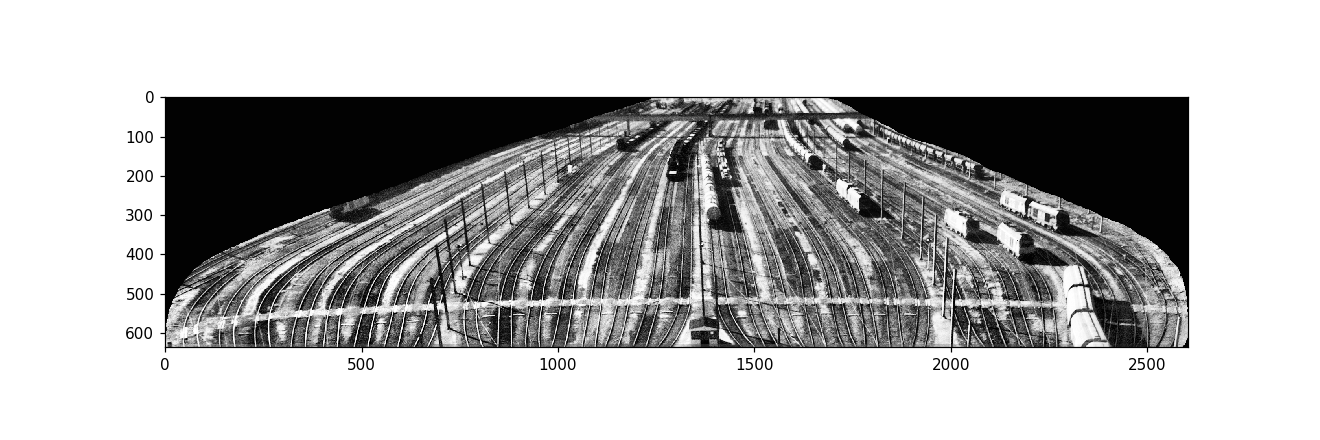

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


<IPython.core.display.Javascript object>


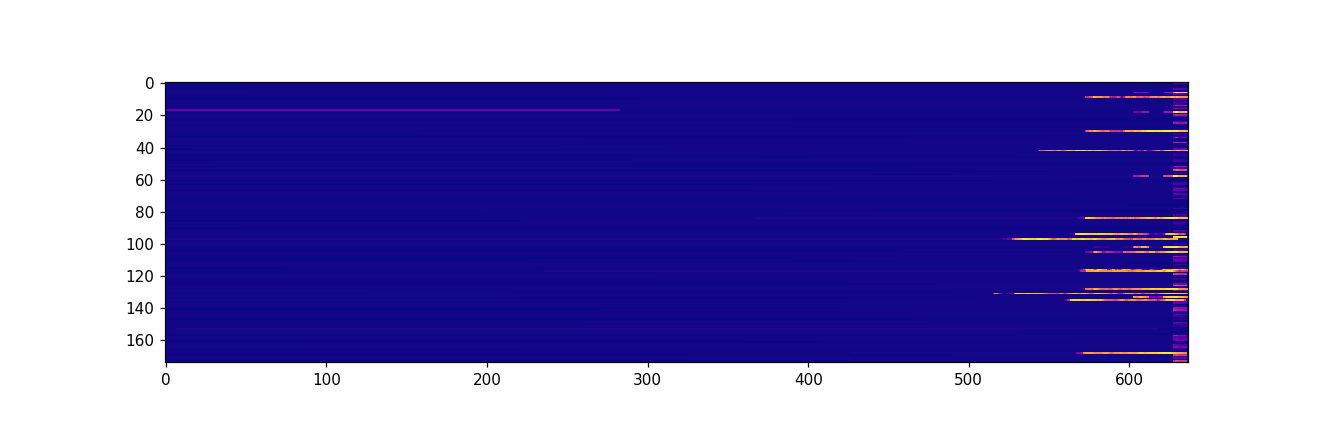

In [82]:
example = allimg[66,:,:]
plt.figure(figsize=(12,4))
plt.imshow(example,cmap='gray')
skimage.io.imsave("example.png",example)
#
diff = example-medimg
diffrelu = np.copy(diff[:,:])
diffrelu[diff<0] = 0
rmsdiff = np.sqrt(np.power(diff,2))
plt.figure(figsize=(12,4))
plt.imshow(diffrelu,cmap="gray")

In [102]:
diffrelu

array([[ 0.69634682,  2.48489292,  0.49903683, ..., 17.55520548,
        18.651257  , 20.19213082],
       [ 0.        ,  2.39681166,  3.53919019, ...,  4.81993097,
        12.66079154, 17.72175681],
       [ 0.        ,  0.        ,  1.02874689, ...,  3.29741764,
         5.99283501,  7.51692148],
       ...,
       [ 0.        ,  2.20580552,  1.84487464, ..., 21.98297918,
        25.50758826, 18.6679167 ],
       [ 0.        ,  0.        ,  6.66373013, ..., 24.23381057,
        20.0657295 , 19.32573113],
       [ 0.        ,  0.        ,  0.        , ..., 25.52960605,
        17.89545754, 13.1090897 ]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


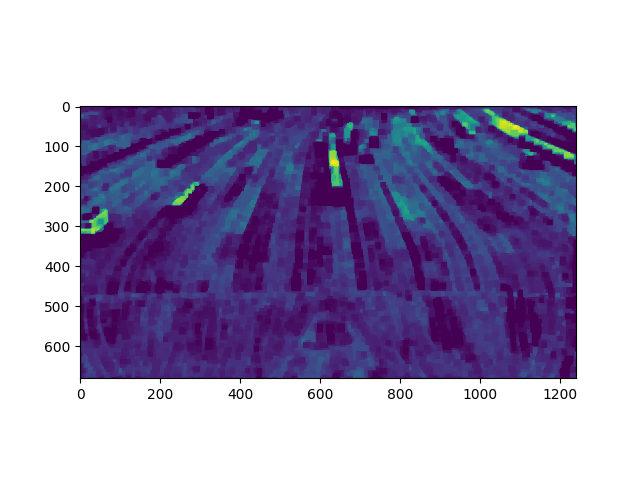

In [192]:
from skimage.morphology import dilation, erosion, opening, closing, square, area_opening
blobs = closing(diffrelu,square(12))
blobs2 = opening(blobs,square(6))
plt.figure()
plt.imshow(blobs2)

<IPython.core.display.Javascript object>


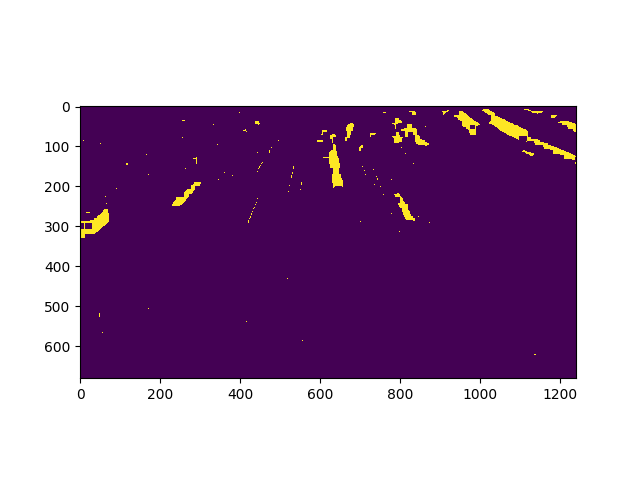

In [122]:
thresh = skimage.filters.threshold_otsu(blobs2)
trains = blobs > (thresh+40)
plt.figure()
plt.imshow(trains)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


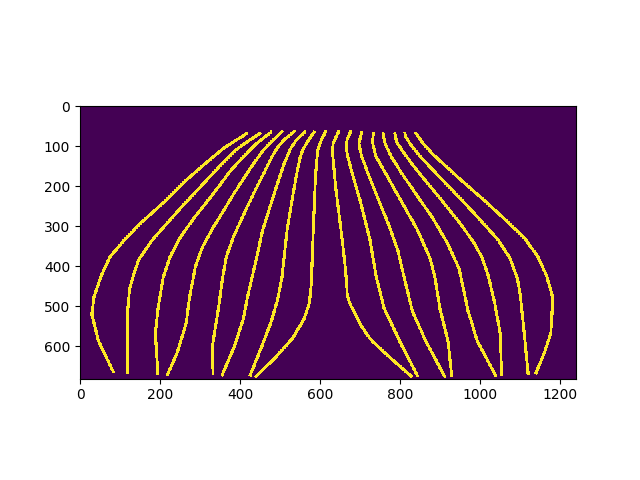

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: voiesbin.png is a low contrast image
  import sys


In [193]:
import skimage.io
voiesurimp = cv2.imread("voiessurimp.png")
voiesbin=(voiesurimp[:,0:1240,0]==0).astype('uint8')
voiesbin = dilation(voiesbin, square(3))
plt.figure()
plt.imshow(voiesbin)
skimage.io.imsave("voiesbin.png",voiesbin)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


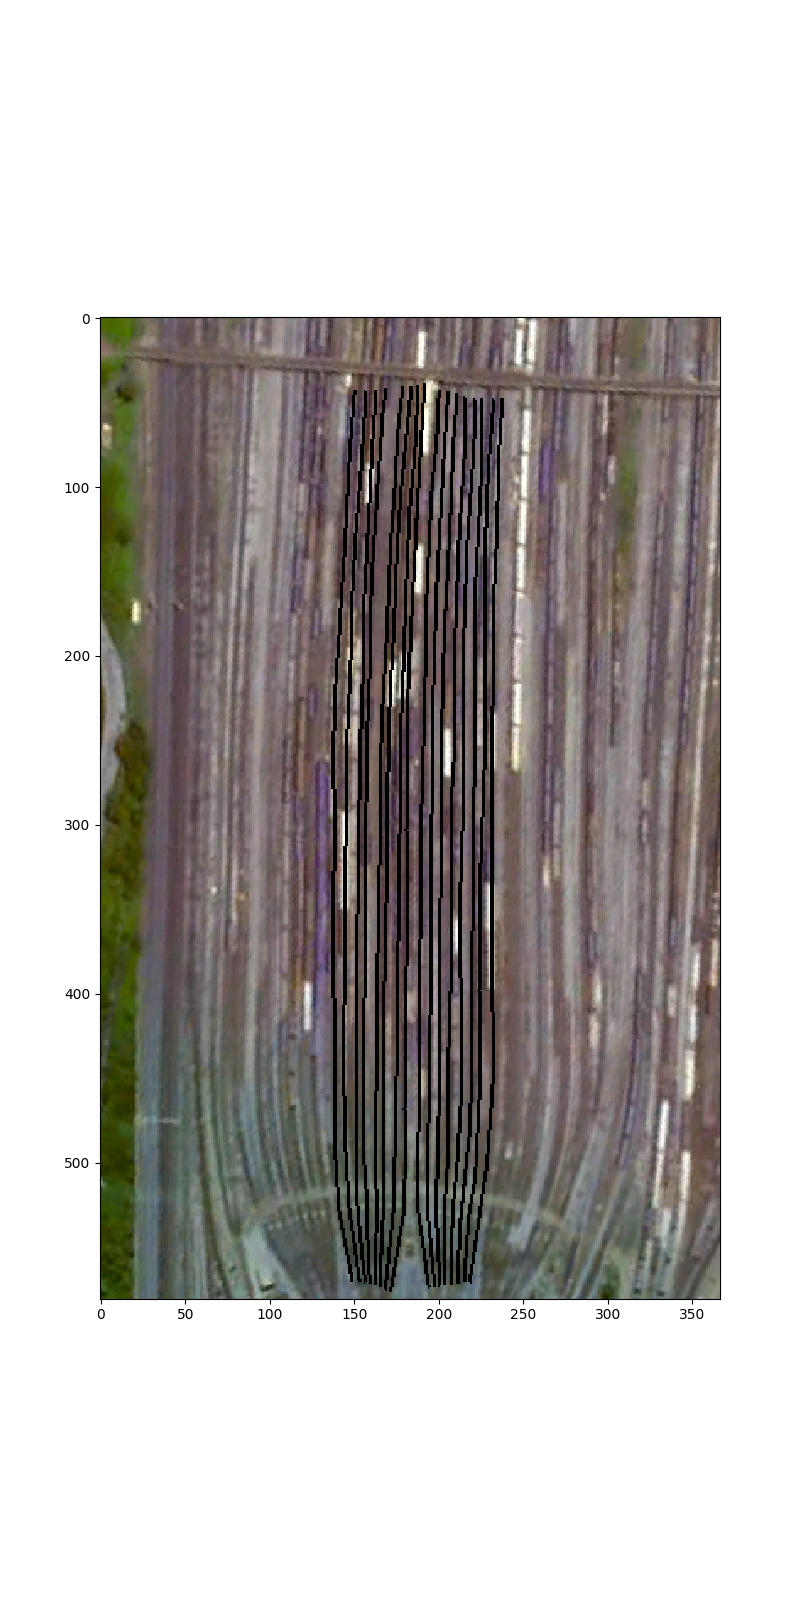

In [197]:
## read the satellite image
satellite = cv2.imread("voies_satellite_surimp.png")    
plt.figure(figsize=(8,16))
plt.imshow(satellite)

In [194]:
## sloggin it the hard way, with corresponding points
## https://www.learnopencv.com/homography-examples-using-opencv-python-c/
#pts_src=np.array([[65,413],[64,838],
#                 [660,83],[673,439]])
#pts_dst=np.array([[43,150],[48,237],
#                  [569,148],[570,218]])
zoom=2

## les coordonnées OpenCV sont dans l'ordre (x,y) 
## alors que les coordonnées numpy sont dans l'ordre (r,c) soit (y,x)
pts_src=np.array([[413,65],[838,64],
                 [83,660],[1140,665]])
pts_dst=np.array([[150,43],[237,48],
                  [148,569],[218,570]])

h, status = cv2.findHomography(pts_src, zoom*pts_dst)
print(status)
print(2*pts_dst)

[[1]
 [1]
 [1]
 [1]]
[[ 300   86]
 [ 474   96]
 [ 296 1138]
 [ 436 1140]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


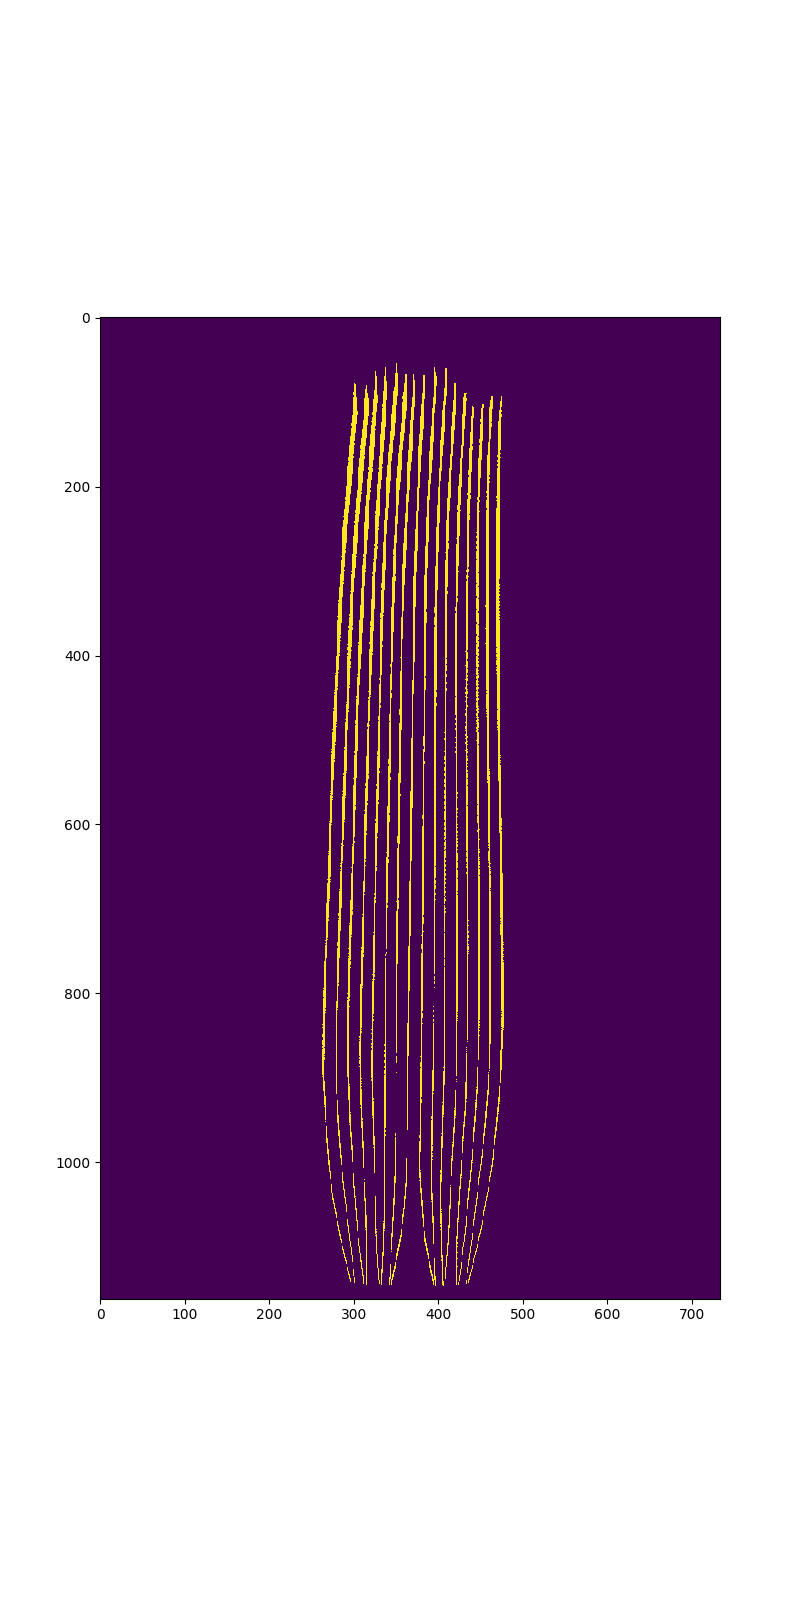

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: voies_camera_warped.png is a low contrast image
  


In [199]:
## do the warping
# Warp camera image to satellite image based on homography

im_out = cv2.warpPerspective(voiesbin, h, (zoom*satellite.shape[1],zoom*satellite.shape[0]),flags=cv2.INTER_NEAREST)
plt.figure(figsize=(8,16))
binary_tracks = dilation(im_out, square(3))
plt.imshow(im_out)
skimage.io.imsave("voies_camera_warped.png",binary_tracks)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


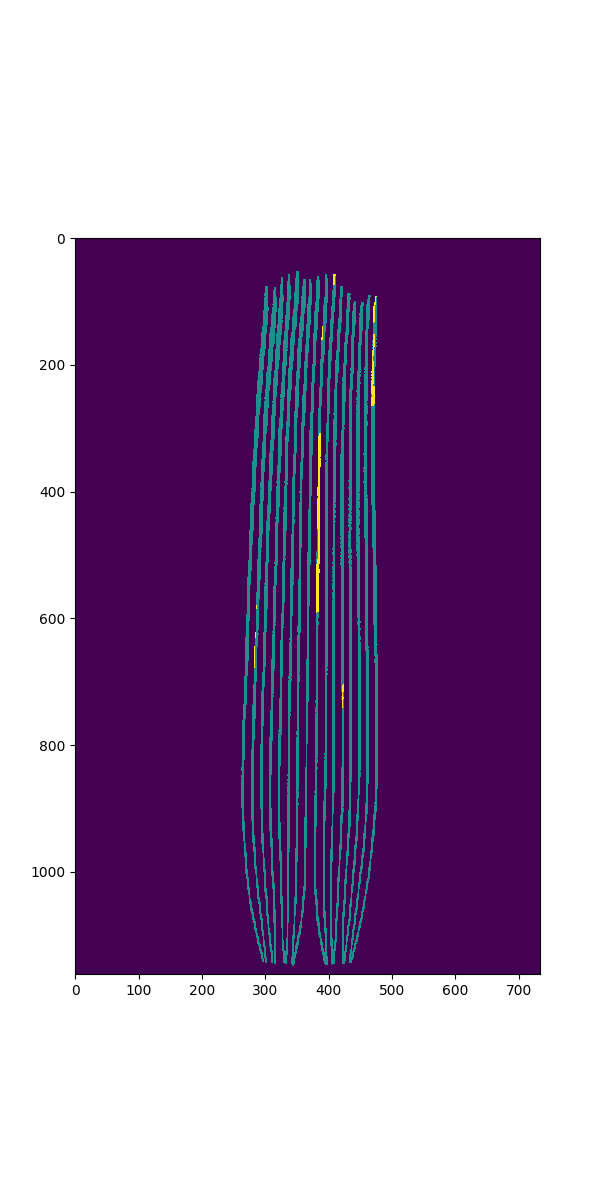

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: voies_camera_warped_detect.png is a low contrast image
  


In [208]:
## exemple de warping de résultat
im_detect = cv2.warpPerspective(blobs2, h, (zoom*satellite.shape[1],zoom*satellite.shape[0]))
## multiply by binary image of track
train_detect = (im_detect * binary_tracks)>70
tracks_trains = train_detect + binary_tracks
plt.figure(figsize=(6,12))
plt.imshow(tracks_trains)
skimage.io.imsave("voies_camera_warped_detect.png",tracks_trains)

In [53]:
skimage.__version__

'0.16.1'

In [52]:
cv2.__version__

'4.1.1'

In [ ]:
True

In [84]:
a='abc'
if (a=='abc'):
    print("ok")

ok
